In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.2'
spark_version = 'spark-3.1.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!wget -q https://jdbc.postgresql.org/download/postgresql-42.2.19.jar
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"
os.environ["SPARK_CLASSPATH"] = f"/content/postgresql-42.2.19.jar"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:13 

In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.executor.memory", "70g").config("spark.driver.memory", "50g").config("spark.memory.offHeap.enabled",True).config("spark.memory.offHeap.size","16g").appName("Vine_analysis")\
.config("spark.jars", "/content/postgresql-42.2.19.jar").getOrCreate()
# Enable Arrow-based columnar data transfers
spark.conf.set("park.sqls.execution.arrow.enabled", "true")
# Increase timeout values
spark.conf.set("spark.sql.broadcastTimeout", "1000")
# disable the broadcasting
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")

# Load data from AWS RDS

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab_Notebooks/Homework/')

In [ ]:
from config import server, database, port, username, password

In [ ]:
# home imprvements
df1 = spark.read.jdbc(url = f"jdbc:postgresql://{server}:{port}/{database}", 
                     table = "(SELECT DISTINCT t2.star_rating, t2.helpful_votes, t2.total_votes, t2.vine, t1.verified_purchase\
                     FROM reviews AS t1 INNER JOIN vine_table AS t2 ON t1.review_id = t2.review_id\
                     AND t2.total_votes>=10 AND t2.helpful_votes/t2.total_votes >= 0.5 AND t2.batch_id =1) AS my_table",
                     properties={"user": f"{username}", "password": f"{password}", "driver": 'org.postgresql.Driver'})
df1.count()

699

In [ ]:
#  musical instruments
df2 = spark.read.jdbc(url = f"jdbc:postgresql://{server}:{port}/{database}", 
                     table = "(SELECT DISTINCT t2.star_rating, t2.helpful_votes, t2.total_votes, t2.vine, t1.verified_purchase\
                     FROM reviews AS t1 INNER JOIN vine_table AS t2 ON t1.review_id = t2.review_id\
                     AND t2.total_votes>=10 AND t2.helpful_votes/t2.total_votes >= 0.5 AND t2.batch_id =2) AS my_table",
                     properties={"user": f"{username}", "password": f"{password}", "driver": 'org.postgresql.Driver'})
df2.count()

421

In [ ]:
df1.createOrReplaceTempView("table1")
df2.createOrReplaceTempView("table2")

In [ ]:
df = spark.sql("SELECT * from table1 UNION ALL SELECT * from table2")
df.show()

+-----------+-------------+-----------+----+-----------------+
|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+-----------+-------------+-----------+----+-----------------+
|          3|           71|         71|   N|                Y|
|          5|           66|         66|   N|                Y|
|          5|           28|         28|   N|                N|
|          5|           40|         40|   N|                Y|
|          2|           37|         37|   N|                Y|
|          1|           35|         35|   N|                N|
|          4|           24|         24|   Y|                N|
|          3|           34|         34|   N|                N|
|          5|           98|         98|   N|                N|
|          5|           32|         32|   N|                N|
|          3|           21|         21|   Y|                N|
|          3|           31|         31|   N|                Y|
|          2|           33|         33|   N|           

In [ ]:
from pyspark.sql.functions import col, avg
df_paid = df.filter("vine='Y'")
df_unpaid = df.filter("vine='N'")

In [ ]:
df_paid.describe().show()

+-------+------------------+------------------+------------------+----+-----------------+
|summary|       star_rating|     helpful_votes|       total_votes|vine|verified_purchase|
+-------+------------------+------------------+------------------+----+-----------------+
|  count|                53|                53|                53|  53|               53|
|   mean| 4.056603773584905| 21.41509433962264| 21.41509433962264|null|             null|
| stddev|1.1165726119146009|15.791226827022253|15.791226827022253|null|             null|
|    min|                 1|                10|                10|   Y|                N|
|    max|                 5|               106|               106|   Y|                Y|
+-------+------------------+------------------+------------------+----+-----------------+



In [ ]:
df_unpaid.describe().show()

+-------+------------------+------------------+------------------+----+-----------------+
|summary|       star_rating|     helpful_votes|       total_votes|vine|verified_purchase|
+-------+------------------+------------------+------------------+----+-----------------+
|  count|              1067|              1067|              1067|1067|             1067|
|   mean| 3.478912839737582| 47.33083411433927| 47.33083411433927|null|             null|
| stddev|1.4373324321598508|35.014446436397016|35.014446436397016|null|             null|
|    min|                 1|                10|                10|   N|                N|
|    max|                 5|               318|               318|   N|                Y|
+-------+------------------+------------------+------------------+----+-----------------+



In [ ]:
df_paid[df_paid['star_rating'] == 5].count()

23

In [ ]:
df_paid.count()

53

In [ ]:
print(f"Percentage of 5 star vine: {round(df_paid[df_paid['star_rating'] == 5].count()/df_paid.count()*100,3)}%")

Percentage of 5 star vine: 43.396%


In [ ]:
df_unpaid[df_unpaid['star_rating'] == 5].count()

350

In [ ]:
df_unpaid.count()

1067

In [ ]:
print(f"Percentage of 5 star non-vine: {round(df_unpaid[df_unpaid['star_rating'] == 5].count()/df_unpaid.count()*100,3)}%")

Percentage of 5 star non-vine: 32.802%


## looking at product categories separately

In [ ]:
# home improvement
df1_paid = df1.filter("vine='Y'")
df1_unpaid = df1.filter("vine='N'")
print(f"Count of 5 star Vines: {df1_paid[df1_paid['star_rating'] == 5].count()}")
print(f"Count of 5 star Non-Vines: {df1_unpaid[df1_unpaid['star_rating'] == 5].count()}")
print(f"Percentage of 5 star vine for home improvement products: {round(df1_paid[df1_paid['star_rating'] == 5].count()/df1_paid.count()*100,3)}%")
print(f"Percentage of 5 star non-vine for home improvement products: {round(df1_unpaid[df1_unpaid['star_rating'] == 5].count()/df1_unpaid.count()*100,3)}%")

Count of 5 star Vines: 17
Count of 5 star Non-Vines: 208
Percentage of 5 star vine for home improvement products: 39.535%
Percentage of 5 star non-vine for home improvement products: 31.707%


In [ ]:
spark.sql("SELECT vine, AVG(star_rating), STD(star_rating) from table1 GROUP BY vine").show()

+----+------------------+--------------------------------+
|vine|  avg(star_rating)|std(CAST(star_rating AS DOUBLE))|
+----+------------------+--------------------------------+
|   Y|3.9302325581395348|              1.1831223588697772|
|   N| 3.410060975609756|              1.4592132134760738|
+----+------------------+--------------------------------+



In [ ]:
# musical instrument
df2_paid = df2.filter("vine='Y'")
df2_unpaid = df2.filter("vine='N'")
print(f"Count of 5 star Vines: {df2_paid[df2_paid['star_rating'] == 5].count()}")
print(f"Count of 5 star Non-Vines: {df2_unpaid[df2_unpaid['star_rating'] == 5].count()}")
print(f"Percentage of 5 star vine for home improvement products: {round(df2_paid[df2_paid['star_rating'] == 5].count()/df2_paid.count()*100,3)}%")
print(f"Percentage of 5 star non-vine for home improvement products: {round(df2_unpaid[df2_unpaid['star_rating'] == 5].count()/df2_unpaid.count()*100,3)}%")

Count of 5 star Vines: 6
Count of 5 star Non-Vines: 142
Percentage of 5 star vine for home improvement products: 60.0%
Percentage of 5 star non-vine for home improvement products: 34.55%


In [ ]:
spark.sql("SELECT vine, AVG(star_rating), STD(star_rating) from table2 GROUP BY vine").show()

+----+-----------------+--------------------------------+
|vine| avg(star_rating)|std(CAST(star_rating AS DOUBLE))|
+----+-----------------+--------------------------------+
|   Y|              4.6|              0.5163977794943222|
|   N|3.588807785888078|              1.3964314413105627|
+----+-----------------+--------------------------------+



In [ ]:
#  all reviews
spark_df = spark.read.jdbc(url = f"jdbc:postgresql://{server}:{port}/{database}", 
                     table = "(SELECT DISTINCT t2.star_rating, t2.helpful_votes, t2.total_votes, t2.vine, t1.verified_purchase, t3.product_category\
                     FROM reviews AS t1 INNER JOIN vine_table AS t2 ON t1.review_id = t2.review_id\
                     AND t2.total_votes>=10 AND t2.helpful_votes/t2.total_votes >= 0.5\
                     INNER JOIN (SELECT DISTINCT batch_id, product_category FROM products) AS t3 ON t1.batch_id = t3.batch_id) AS my_table",
                     properties={"user": f"{username}", "password": f"{password}", "driver": 'org.postgresql.Driver'})
spark_df.count()

1120

In [ ]:
spark_df.show()

+-----------+-------------+-----------+----+-----------------+-------------------+
|star_rating|helpful_votes|total_votes|vine|verified_purchase|   product_category|
+-----------+-------------+-----------+----+-----------------+-------------------+
|          5|           60|         60|   N|                Y|Musical Instruments|
|          3|           29|         29|   N|                Y|Musical Instruments|
|          4|           34|         34|   N|                Y|   Home Improvement|
|          5|           36|         36|   N|                Y|Musical Instruments|
|          4|           64|         64|   N|                N|   Home Improvement|
|          5|           16|         16|   N|                Y|Musical Instruments|
|          3|           28|         28|   N|                Y|   Home Improvement|
|          2|           18|         18|   N|                Y|   Home Improvement|
|          1|           38|         38|   N|                N|   Home Improvement|
|   

In [ ]:
pandas_df = spark_df.groupBy(["product_category", "vine", "verified_purchase"]).mean().toPandas()
pandas_df.head(10)

,product_category,vine,verified_purchase,avg(star_rating),avg(helpful_votes),avg(total_votes)
0,Home Improvement,N,Y,3.500000,57.301105,57.301105
1,Home Improvement,Y,N,3.930233,23.000000,23.000000
2,Musical Instruments,Y,N,4.555556,14.777778,14.777778
3,Musical Instruments,N,N,3.608491,41.985849,41.985849
4,Musical Instruments,N,Y,3.567839,36.733668,36.733668
5,Home Improvement,N,N,3.299320,46.081633,46.081633
6,Musical Instruments,Y,Y,5.000000,13.000000,13.000000


In [ ]:
pandas_df.sort_values(by="product_category", inplace= True)
pandas_df.reset_index(inplace= True, drop = True)
pandas_df.head(10)

,product_category,vine,verified_purchase,avg(star_rating),avg(helpful_votes),avg(total_votes)
0,Home Improvement,N,Y,3.500000,57.301105,57.301105
1,Home Improvement,Y,N,3.930233,23.000000,23.000000
2,Home Improvement,N,N,3.299320,46.081633,46.081633
3,Musical Instruments,Y,N,4.555556,14.777778,14.777778
4,Musical Instruments,N,N,3.608491,41.985849,41.985849
5,Musical Instruments,N,Y,3.567839,36.733668,36.733668
6,Musical Instruments,Y,Y,5.000000,13.000000,13.000000


In [ ]:
pandas_df1 = pandas_df[pandas_df["product_category"]=="Home Improvement"].groupby(["product_category",	"vine"], as_index=False).mean()
pandas_df1.set_index("vine", inplace=True)
pandas_df1

,product_category,avg(star_rating),avg(helpful_votes),avg(total_votes)
vine,,,,
N,Home Improvement,3.399660,51.691369,51.691369
Y,Home Improvement,3.930233,23.000000,23.000000


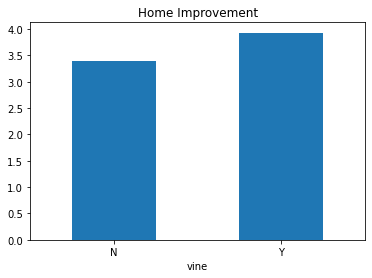

In [ ]:
pandas_df1["avg(star_rating)"].plot(kind='bar', rot=0, title = "Home Improvement")

In [ ]:
pandas_df2 = pandas_df[pandas_df["product_category"]=="Musical Instruments"].groupby(["product_category",	"vine"], as_index=False).mean()
pandas_df2.set_index("vine", inplace=True)
pandas_df2

,product_category,avg(star_rating),avg(helpful_votes),avg(total_votes)
vine,,,,
N,Musical Instruments,3.588165,39.359759,39.359759
Y,Musical Instruments,4.777778,13.888889,13.888889


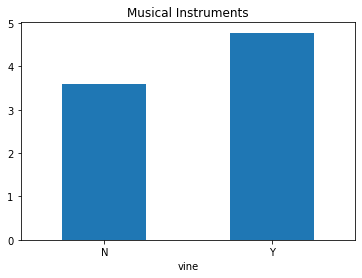

In [ ]:
pandas_df2["avg(star_rating)"].plot(kind='bar', rot=0, title = "Musical Instruments")

# Conclusion

* We can see that the percentage of 5-star reviews in Vine is not close to non-Vine reviews (43.396% to 32.802%). Which means that vine reviews are biased not accurate.

* Although the number of Vine reviews is pretty low, so far it can still represent the product. However, the average rating from Vine customers is 4.05  with std deviation of 1.12, whereas the average rating from Vine customers is 3.48 with std deviation of 1.44.

* The average rating for vines varies from category to category. For example, average rating for musical instruments is way higher than home improvement products. So be careful when purchasing musical instruments as the vine reviews might skew your view. 

* I believe the Vine customers tend to give higher ratings and pretty focusing on the higher ratings too. So reviews from Vine customers are not that trustworthy for me.